In [2]:
from qiskit import Aer, QuantumCircuit, QuantumRegister, ClassicalRegister, execute
from qiskit.aqua.algorithms import AmplitudeEstimation
from qiskit.circuit.library import QFT, GroverOperator

from qiskit.aqua.algorithms.amplitude_estimators.q_factory import QFactory

import math
import numpy as np
import matplotlib.pyplot as plt

In [404]:
evaluation_qubits = 7

probability = 0.4567
theta = 2 * np.arcsin(np.sqrt(probability))

evaluation_registry = QuantumRegister(evaluation_qubits, 'evaluation')
a_registry = QuantumRegister(1, 'q')

## First with the Qiskit function

In [405]:
a_factory =  QuantumCircuit(a_registry)
a_factory.ry(theta, a_registry[0])
backend = Aer.get_backend('statevector_simulator')
job = execute(a_factory, backend, shots=1024)
counts = job.result().get_counts()
print(counts)

{'0': 0.5433, '1': 0.4567}


In [406]:
ae = AmplitudeEstimation(evaluation_qubits, a_factory)
ae_result = ae.run(quantum_instance=Aer.get_backend('qasm_simulator'))

In [407]:
ae_result

{'a_estimation': 0.4509914, 'confidence_interval': [0.4564868630015216, 0.4573113137098864], 'estimation': 0.4509914, 'num_oracle_queries': 130048, 'ml_value': 0.45689521995868704, 'mapped_a_samples': [0.1295244, 0.1464466, 0.2222149, 0.2643016, 0.2862225, 0.3086583, 0.3315551, 0.3548577, 0.3785099, 0.4024548, 0.4266348, 0.4509914, 0.4754662, 0.5, 0.5245338, 0.5490086, 0.5733652, 0.5975452, 0.6214901, 0.6451423, 0.8171966, 0.9157348], 'probabilities': [0.0009765625, 0.0009765625, 0.001953125, 0.001953125, 0.001953125, 0.001953125, 0.0009765625, 0.005859375, 0.00390625, 0.009765625, 0.0322265625, 0.8212890625, 0.0830078125, 0.01171875, 0.0068359375, 0.00390625, 0.00390625, 0.001953125, 0.001953125, 0.0009765625, 0.0009765625, 0.0009765625], 'shots': 1024, 'mle': 0.45689521995868704, 'circuit_result': {'0010010': 1, '0010011': 5, '0010100': 1, '0010110': 1, '0011011': 1, '0011100': 5, '0011101': 1, '0000010': 6, '0100010': 3, '0100011': 416, '0101011': 1, '0101100': 3, '0000011': 6, '011

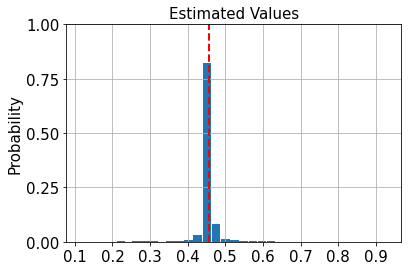

In [408]:
# plot estimated values
plt.bar(ae_result['mapped_a_samples'], ae_result['probabilities'], width=0.5/len(ae_result['probabilities']))
plt.plot([probability, probability], [0,1], 'r--', linewidth=2)
plt.xticks(size=15)
plt.yticks([0, 0.25, 0.5, 0.75, 1], size=15)
plt.title('Estimated Values', size=15)
plt.ylabel('Probability', size=15)
plt.ylim((0,1))
plt.grid()
plt.show()

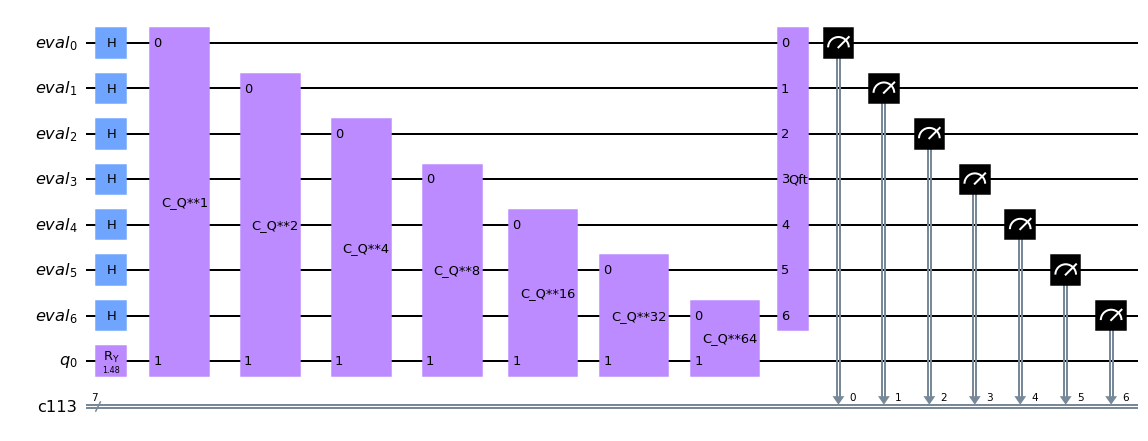

In [409]:
ae._circuit.draw('mpl')

Q Operator

$$ \mathcal{Q} = \mathcal{A} \mathcal{S}_0 \mathcal{A}^\dagger \mathcal{S}_f, $$

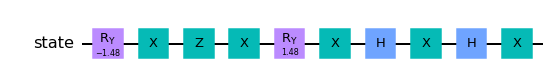

In [410]:
test_gate = ae.grover_operator.inverse().to_gate().control(1)
ae.grover_operator.inverse().draw('mpl')

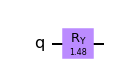

In [411]:
ae.state_preparation.draw('mpl')

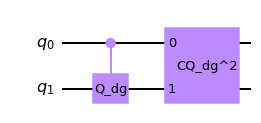

In [412]:
q_test = QuantumCircuit(2)
q_test.append(test_gate, [0,1])
q_test.append(test_gate.power(2), [0,1])
q_test.draw('mpl')

## Design our own AE

In [413]:
def qft_dagger(qc, n):
    """n-qubit QFTdagger the first n qubits in circ"""
    # Don't forget the Swaps!
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cp(-math.pi/float(2**(j-m)), m, j)
        qc.h(j)



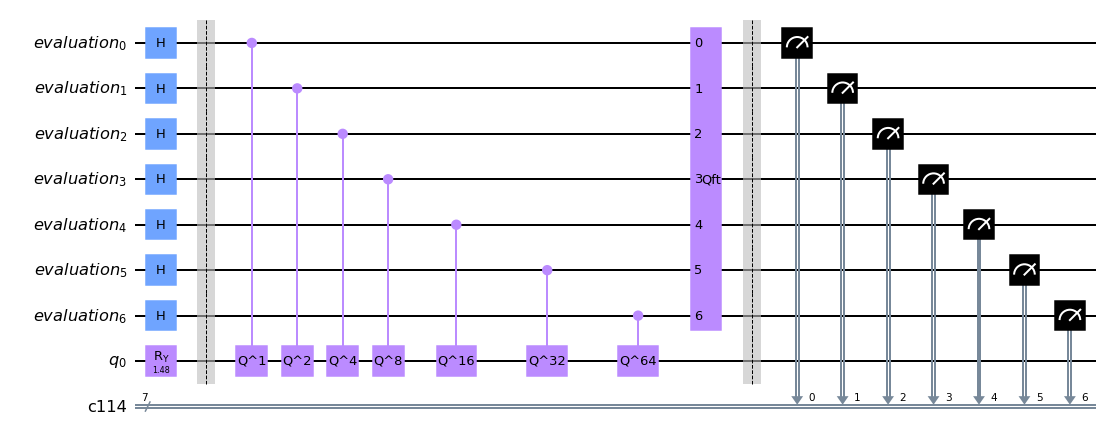

In [414]:
cr = ClassicalRegister(evaluation_qubits)
qc = QuantumCircuit(evaluation_registry, a_registry, cr)

#qc.append(a_operator(), a_registry)

# A
qc.ry(theta, a_registry)

qc.h(range(evaluation_qubits))
qc.barrier()
#Do the controlled-U operations:
# 𝑄=𝐴𝑆0𝐴−1𝑆𝜓0
repetitions = 1
for counting_qubit in range(evaluation_qubits):
    
    q_op = QuantumCircuit(1)
    
    # Spsi
#    q_op.x(0)
    q_op.z(0)
#    q_op.x(0)

    # A
    q_op.ry(-theta*repetitions, 0)
    
    # S0
    #q_op.x(0)
    q_op.z(0)
    #q_op.x(0)
    
    # A
    q_op.ry(theta*repetitions, 0)
    
    label = "Q^"+str(repetitions)
    
    qc.append(q_op.to_gate(label=label).control(1), [counting_qubit, evaluation_qubits])
    repetitions *= 2
    
#qft_dagger(qc, evaluation_qubits)
qc.append(QFT(evaluation_qubits, inverse=True, do_swaps=False), range(evaluation_qubits))
qc.barrier()
qc.measure(range(evaluation_qubits), cr)
qc.draw('mpl')

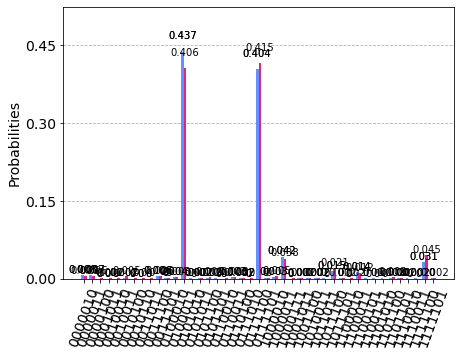

In [415]:
from qiskit.visualization import plot_histogram

backend = Aer.get_backend('qasm_simulator')
results = execute(qc, backend=backend, shots=1024).result()
counts = results.get_counts()

plot_histogram([counts, ae_result['circuit_result']])

In [437]:
from qiskit import IBMQ
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
IBMQ.load_account()
provider = IBMQ.get_provider()
backend_real = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits > evaluation_qubits+1 and not x.configuration().simulator ))
backend_real.name()

job_real = execute(qc, backend=backend, shots=1024)
job_monitor(job_real)
results_real = job_real.result()


/Users/sergiogago/opt/anaconda3/lib/python3.7/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning:

Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.

ibmqfactory.load_account:WARNING:2021-01-31 19:38:40,531: Credentials are already in use. The existing account in the session will be replaced.


Job Status: job has successfully run


In [440]:
results_real = job_real.result()
counts_real = results_real.get_counts()

In [444]:
from kaleidoscope import probability_distribution

probability_distribution([counts, ae_result['circuit_result'], counts_real], legend=['Sim Manual', 'Sim Qiskit Aqua', 'Melbourne16'], figsize=(1024,600))

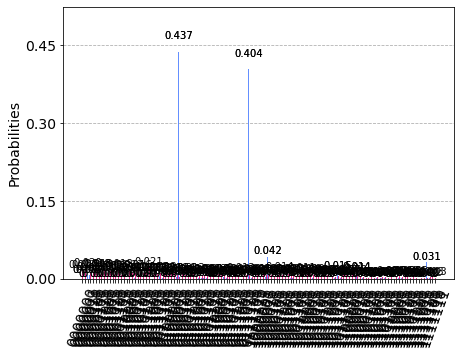

In [443]:
from qiskit.visualization import plot_histogram

plot_histogram([counts,counts_real])

In [416]:
print(ae_result['circuit_result'])
print(counts)

{'0010010': 1, '0010011': 5, '0010100': 1, '0010110': 1, '0011011': 1, '0011100': 5, '0011101': 1, '0000010': 6, '0100010': 3, '0100011': 416, '0101011': 1, '0101100': 3, '0000011': 6, '0110010': 1, '0110011': 3, '0110100': 1, '0111010': 1, '0111100': 425, '0111101': 1, '0000100': 1, '1000010': 5, '1000011': 39, '1000111': 1, '1001011': 2, '1001100': 1, '1010011': 1, '1011100': 21, '1011101': 2, '1100010': 2, '1100011': 12, '1101100': 3, '1101101': 2, '1111100': 46, '1111101': 2, '0001011': 2}
{'0010011': 2, '0011100': 6, '0011101': 1, '0000010': 8, '0100010': 4, '0100011': 447, '0101010': 1, '0101011': 2, '0101100': 2, '0101101': 1, '0000011': 7, '0110011': 3, '0110100': 2, '0111100': 414, '0111101': 1, '1000010': 3, '1000011': 43, '1001011': 1, '1001100': 1, '1010011': 2, '1011011': 1, '1011100': 15, '1011101': 1, '1100011': 14, '1100101': 1, '1100111': 1, '1101010': 1, '1101100': 2, '1101101': 1, '1110010': 1, '1110011': 2, '1111100': 32, '1111101': 1}


In [451]:
# REason for decoherence and noise?
#transpiled_circuit = qc.transpiled_circuit
from qiskit import transpile
qc_transpiled = transpile(qc, backend_real , optimization_level=3)

In [450]:
print(qc_transpiled.depth())
print(qc_transpiled.size())

322
733


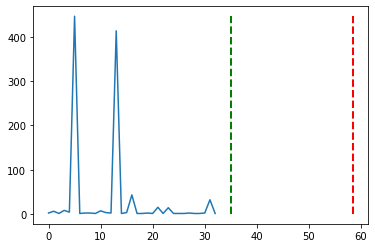

In [417]:
# TODO: Wrong calculation
plt.plot(counts.values())
# Real (Red)
plt.plot([probability * 2**evaluation_qubits, probability * 2**evaluation_qubits], [0,max(counts.values())], 'r--', linewidth=2)
# Calculated (Green)
plt.plot([int(max(counts, key=counts.get),2), int(max(counts, key=counts.get),2)], [0,max(counts.values())], 'g--', linewidth=2)
plt.show()

In [422]:
# TODO: This is not correct

print("Most probably state: ", max(counts, key=counts.get), "-- ", int(max(counts, key=counts.get),2))
estimated_probability = int(max(counts, key=counts.get),2) / 2**evaluatioan_qubits
print("Estimated Probability: theta = state / 2^n :", estimated_probability)
print("Real Probability: ", probability)
print("Error: ", estimated_probability - probability)

#theta = 2 * np.arcsin(np.sqrt(probability))

# a = sin2 (θ) (approx)
print(theta)
print((np.sin(estimated_probability/2))**2)

Most probably state:  0100011 --  35
Estimated Probability: theta = state / 2^n : 0.2734375
Real Probability:  0.4567
Error:  -0.1832625
1.484087716205598
0.01857584264531015


In [284]:
for i in counts:
    estimated_probability = int(i,2) / 2**evaluation_qubits
    print(i, " : ", counts[i], " - ", estimated_probability)

010000  :  2  -  0.25
010011  :  2  -  0.296875
010100  :  5  -  0.3125
010101  :  1  -  0.328125
010111  :  2  -  0.359375
011000  :  1  -  0.375
011010  :  1  -  0.40625
011011  :  2  -  0.421875
011100  :  5  -  0.4375
011101  :  1  -  0.453125
100010  :  2  -  0.53125
100011  :  3  -  0.546875
100100  :  5  -  0.5625
101001  :  1  -  0.640625
101011  :  29  -  0.671875
101100  :  21  -  0.6875
000011  :  1  -  0.046875
110010  :  1  -  0.78125
110011  :  8  -  0.796875
110100  :  25  -  0.8125
110111  :  1  -  0.859375
111001  :  1  -  0.890625
111100  :  2  -  0.9375
000101  :  2  -  0.078125
000111  :  1  -  0.109375
001000  :  2  -  0.125
001010  :  1  -  0.15625
001011  :  426  -  0.171875
001100  :  470  -  0.1875


Grover operator examples

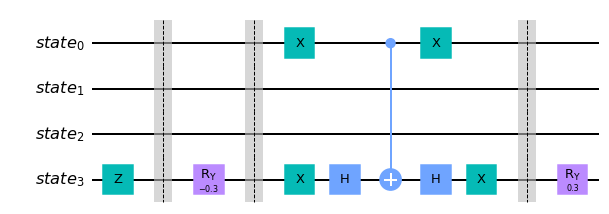

In [143]:
oracle = QuantumCircuit(4)
oracle.z(3)
reflection_qubits = [0, 3]
state_preparation = QuantumCircuit(4)
state_preparation.ry(0.3, 3)
grover_op = GroverOperator(oracle, state_preparation, reflection_qubits=reflection_qubits, insert_barriers=True)
grover_op.draw('mpl')

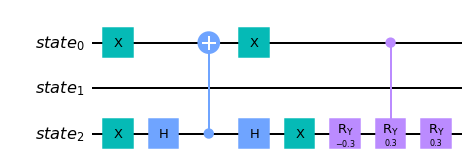

In [156]:
state_preparation = QuantumCircuit(3)

oracle = QuantumCircuit(3)
oracle.x([2,0])
oracle.h(2)
oracle.mcx([2],0)
oracle.h(2)
oracle.x([2,0])

zero_reflection = QuantumCircuit(3)
zero_reflection.cry(0.3, 0, 2)

state_preparation.ry(0.3, 2)
grover_op = GroverOperator(oracle, state_preparation, reflection_qubits=[0,3], zero_reflection=zero_reflection)
grover_op.draw('mpl')

In [340]:
    state_preparation = QuantumCircuit(evaluation_qubits+1)
    oracle = QuantumCircuit(evaluation_qubits+1)
    oracle.x(evaluation_qubits)
    oracle.z(evaluation_qubits)
    oracle.x(evaluation_qubits)
    state_preparation.ry(theta*repetitions, evaluation_qubits)
    grover_op = GroverOperator(oracle, state_preparation)
    grover_op.draw()

┌───┐                                        ┌───┐                   
state_0: ┤ X ├─────────────────────────────────────■──┤ X ├───────────────────
         ├───┤                                     │  ├───┤                   
state_1: ┤ X ├─────────────────────────────────────■──┤ X ├───────────────────
         ├───┤                                     │  ├───┤                   
state_2: ┤ X ├─────────────────────────────────────■──┤ X ├───────────────────
         ├───┤                                     │  ├───┤                   
state_3: ┤ X ├─────────────────────────────────────■──┤ X ├───────────────────
         ├───┤                                     │  ├───┤                   
state_4: ┤ X ├─────────────────────────────────────■──┤ X ├───────────────────
         ├───┤                                     │  ├───┤                   
state_5: ┤ X ├─────────────────────────────────────■──┤ X ├───────────────────
         ├───┤┌───┐┌───┐┌─────────────┐┌───┐┌───┐┌─┴─┐├───┤┌───┐┌────────────┐
state_6: ┤ X ├┤ Z ├┤ X ├┤ RY(-1.1593) ├┤ X ├┤ H ├┤ X ├┤ H ├┤ X ├┤ RY(1.1593) ├
         └───┘└───┘└───┘└─────────────┘└───┘└───┘└───┘└───┘└───┘└────────────┘

## Next steps

Clearly with "standard" QAE out of the box, even if we could optimize the circuit, we won't go far on current NISQ computers. Circuit depth is too big to get any decent result.

Let's try with IAE

In [452]:
from qiskit.aqua.algorithms import IterativeAmplitudeEstimation

epsilon = 0.01
alpha = 0.05

# construct amplitude estimation
iae = IterativeAmplitudeEstimation(state_preparation=a_factory,
                                  epsilon=epsilon, alpha=alpha)
iae_result = iae.run(quantum_instance=Aer.get_backend('qasm_simulator'), shots=1000)

In [455]:
print(iae_result)

print("Estimation: ", iae_result['estimation'])
print("Real probability: ", probability)

{'confidence_interval': [0.44893614670412985, 0.4612015100056504], 'estimation': 0.45506882835489015, 'num_oracle_queries': 3000, 'value_confidence_interval': [0.44893614670412985, 0.4612015100056504], 'alpha': 0.05, 'actual_epsilon': 0.00613268165076028, 'a_intervals': [[0.0, 1.0], [0.40950228711760434, 0.49499970895692635], [0.44893614670412985, 0.4612015100056504]], 'theta_intervals': [[0, 0.25], [0.11051701958126316, 0.12420416569777154], [0.11685874097138474, 0.11881881479784526]], 'powers': [0, 0, 3], 'ratios': [1.0, 7.0]}
Estimation:  0.45506882835489015
Real probability:  0.4567


In [471]:
## Run IAE on a real device

IBMQ.load_account()
provider = IBMQ.get_provider()
backend_real = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits > 1 and not x.configuration().simulator ))
backend_real.name()
iae_real_result = iae.run(quantum_instance=backend_real, shots=1000)


ibmqfactory.load_account:WARNING:2021-02-01 16:27:26,568: Credentials are already in use. The existing account in the session will be replaced.


In [472]:
iae_real_result

{'confidence_interval': [0.4597835537942955, 0.46761565644121006], 'estimation': 0.46369960511775277, 'num_oracle_queries': 5000, 'value_confidence_interval': [0.4597835537942955, 0.46761565644121006], 'alpha': 0.05, 'actual_epsilon': 0.0039160513234572925, 'a_intervals': [[0.0, 1.0], [0.4759868915286301, 0.5618144137132131], [0.4597835537942955, 0.46761565644121006]], 'theta_intervals': [[0, 0.25], [0.12117672438411523, 0.1348633044317983], [0.11859243217958598, 0.11984226124417345]], 'powers': [0, 0, 5], 'ratios': [1.0, 11.0]}